# CNN Model (Binary) for shifted MIT data
As we concluded before, for MIT data, we apply the following preprocessing:   
resampling: Oversampling \
rescaling: MinMax Scaler

If you don't have the original files: run the notebook 'preprocessing_mit_binary_shift_minmax_oversampling.ipynb'
Input file: (The preprocessed data)   
mitbih_binary_train_shift_minmax_oversampling.csv   
mitbih_binary_test_shift_minmax_oversampling.csv

Output: CNN model trained  
model_mit_binary_shift_cnn.h5


In [1]:
import sys
import os

data_path = ''
model_output_path = ''
# check if the enviorment is Google Colab

if 'google.colab' in sys.modules:
    print("Running on Google Colab")
    # Install required libraries
    !pip install scikit-learn -q
    !pip install pandas -q
    !pip install numpy -q
    !pip install imbalanced-learn -q
    !pip install matplotlib -q
    !pip install seaborn -q

    # Mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive')
    # set the path where the csv file stored in your google drive.
    data_path = '/content/drive/MyDrive/heartbeat-deep-model/'
    model_output_path = data_path

else:
    print("Running on local environment")

    current_path = os.getcwd()
    print("Current working directory:", current_path)
    data_path = '../data/processed/'
    model_output_path = '../models/'

Running on Google Colab
Mounted at /content/drive


## Read data


In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, confusion_matrix, classification_report, roc_curve, auc
from imblearn.pipeline import Pipeline as ImbPipeline  # Use ImbPipeline for oversampling
import matplotlib.pyplot as plt
import seaborn as sns

RawFiles = dict({
    'train': data_path + 'mitbih_binary_train_shift_minmax_oversampling.csv',
    'test': data_path + 'mitbih_binary_test_shift_minmax_oversampling.csv'
})

OutputFiles = dict({
    'model': model_output_path +  'model_mit_binary_shift_cnn'
})

train = pd.read_csv(RawFiles.get('train'),sep=',',header=0)
test = pd.read_csv(RawFiles.get('test'),sep=',',header=0)

y_train = train['target']
X_train = train.drop('target', axis=1)

y_test = test['target']
X_test = test.drop('target', axis=1)



In [3]:
# Convert DataFrames to NumPy arrays
X_train = X_train.values
X_test = X_test.values

# Reshape data for (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Check the shape
print("X_train shape:", X_train.shape)  # Should be (num_samples, timesteps, 1)
print("X_test shape:", X_test.shape)    # Should be (num_samples, timesteps, 1)


X_train shape: (144942, 187, 1)
X_test shape: (20284, 187, 1)


# 1D CNN with MinMax Scaler and Oversampling

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
from sklearn.metrics import roc_curve, confusion_matrix, classification_report, f1_score

# Seed
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

# Define the 1D CNN model
model = Sequential()
model.add(Conv1D(187, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

model.add(Conv1D(64, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.01,
    patience=10,
    verbose=1,
    mode='min',
    restore_best_weights=True
)

reduce_learning_rate = ReduceLROnPlateau(
    monitor="val_loss",
    min_delta=0.01,
    patience=3,
    factor=0.1,
    cooldown=4,
    verbose=1
)

# Train Model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_learning_rate],
    verbose=1
)

# Train Scores
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

print(f"Final Loss: {train_loss[-1]:.4f}, Val Loss: {val_loss[-1]:.4f}, "
      f"Accuracy: {train_accuracy[-1]:.4f}, Val Accuracy: {val_accuracy[-1]:.4f}")

# Prediction
y_pred = model.predict(X_test).ravel()  # Flatten y_pred to 1D array
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold: {optimal_threshold:.2f}")
y_pred_class = (y_pred >= optimal_threshold).astype(int)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 185, 187)            │             748 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 185, 187)            │             748 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 92, 187)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 92, 187)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 90, 64)              │          35,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 90, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 45, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 45, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2880)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         184,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 222,169 (867.85 KB)

 Trainable params: 221,667 (865.89 KB)

 Non-trainable params: 502 (1.96 KB)

Epoch 1/100
9059/9059 ━━━━━━━━━━━━━━━━━━━━ 37s 3ms/step - accuracy: 0.8730 - loss: 0.2945 - val_accuracy: 0.9763 - val_loss: 0.0789 - learning_rate: 0.0010
Epoch 2/100
9059/9059 ━━━━━━━━━━━━━━━━━━━━ 35s 3ms/step - accuracy: 0.9361 - loss: 0.1569 - val_accuracy: 0.9739 - val_loss: 0.0763 - learning_rate: 0.0010
Epoch 3/100
9059/9059 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - accuracy: 0.9456 - loss: 0.1381 - val_accuracy: 0.9758 - val_loss: 0.0794 - learning_rate: 0.0010
Epoch 4/100
9047/9059 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9513 - loss: 0.1252
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
9059/9059 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - accuracy: 0.9513 - loss: 0.1252 - val_accuracy: 0.9776 - val_loss: 0.0733 - learning_rate: 0.0010
Epoch 5/100
9059/9059 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - accuracy: 0.9574 - loss: 0.1052 - val_accuracy: 0.9787 - val_loss: 0.0691 - learning_rate: 1.0000e-04
Epoch 6/100
9059/9059 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - accu

In [5]:
# Evaluation Test
from sklearn.metrics import confusion_matrix, classification_report, f1_score

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_class))
print("\nClassification Report:\n", classification_report(y_test, y_pred_class))
print(f"F1 Score: {f1_score(y_test, y_pred_class):.4f}")

Confusion Matrix:
 [[17493   625]
 [   79  2087]]

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.97      0.98     18118
         1.0       0.77      0.96      0.86      2166

    accuracy                           0.97     20284
   macro avg       0.88      0.96      0.92     20284
weighted avg       0.97      0.97      0.97     20284

F1 Score: 0.8557


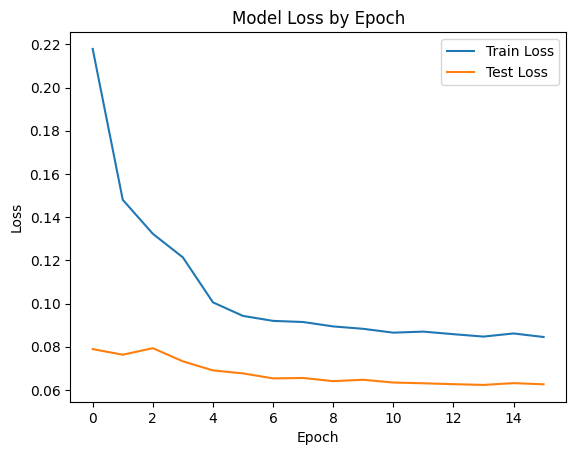

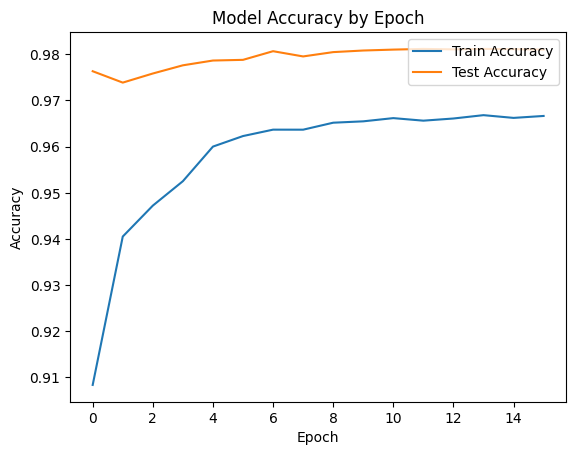

634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Confusion Matrix:
 [[17810   308]
 [  122  2044]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.98      0.99     18118
         1.0       0.87      0.94      0.90      2166

    accuracy                           0.98     20284
   macro avg       0.93      0.96      0.95     20284
weighted avg       0.98      0.98      0.98     20284

F1 Score: 0.9048


In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, f1_score

# Plotting the Loss
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Test Loss')
plt.title('Model Loss by Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# Plotting the Accuracy
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Test Accuracy')
plt.title('Model Accuracy by Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# Making predictions
y_pred = model.predict(X_test)
y_pred_class = (y_pred >= 0.5).astype(int)

# Evaluating the model
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_class))
print("\nClassification Report:\n", classification_report(y_test, y_pred_class))
print(f"F1 Score: {f1_score(y_test, y_pred_class):.4f}")


# Save model

In [7]:
# Save the model in HDF5 format
model_path = OutputFiles.get('model') + '.h5' # Save as HDF5 file format
model.save(model_path)
print(f"Model saved to {model_path}")


Model saved to /content/drive/MyDrive/heartbeat-deep-model/model_mit_binary_shift_cnn.h5


In [8]:
from datetime import datetime
# Display the running time
print("Current time:", datetime.now())

Current time: 2024-12-10 15:18:34.370114
